<h1 align='center'>MACHINE LEARNING PROJECT</h1>
<h2 align='center'>EUROPEAN SOCCER REGRESSION ANALYSIS</h2>

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_columns',80)

### Fetching Data from Database

In [2]:
db = sqlite3.connect('Data/database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", db)
df.head(2)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


In [3]:
df.shape

(183978, 42)

In [4]:
df.to_csv('European Soccer Data.csv')

In [5]:
# Checking for Categoriccal Features

for i in df.columns:
    if (i == 'date') :
        continue
    elif df[i].dtypes == object:
        print(f'\n{i}\nUnique Elements : {df[i].unique()} \nNo.of Unique Elements : {len(df[i].unique())}')


preferred_foot
Unique Elements : ['right' 'left' None] 
No.of Unique Elements : 3

attacking_work_rate
Unique Elements : ['medium' 'high' None 'low' 'None' 'le' 'norm' 'stoc' 'y'] 
No.of Unique Elements : 9

defensive_work_rate
Unique Elements : ['medium' 'high' 'low' '_0' None '5' 'ean' 'o' '1' 'ormal' '7' '2' '8' '4'
 'tocky' '0' '3' '6' '9' 'es'] 
No.of Unique Elements : 20


In [6]:
# Checking for NULL Values

df_null = pd.DataFrame()
df_null['Count'] = df.isnull().sum()
df_null['%'] = (df_null['Count']/df.shape[0]) * 100
df_null.sort_values(by='%', inplace=True, ascending=False)
df_null.head(10)

,Count,%
attacking_work_rate,3230,1.755645
agility,2713,1.474633
jumping,2713,1.474633
curve,2713,1.474633
volleys,2713,1.474633
balance,2713,1.474633
vision,2713,1.474633
sliding_tackle,2713,1.474633
standing_tackle,836,0.454402
marking,836,0.454402


In [7]:
df_mean_median = df.describe().T[['mean', '50%']]
df_mean_median['difference'] = abs(df_mean_median['mean'] - df_mean_median['50%'])
df_mean_median.head(10)

,mean,50%,difference
id,91989.500000,91989.5,0.000000
player_fifa_api_id,165671.524291,183488.0,17816.475709
player_api_id,135900.617324,77741.0,58159.617324
overall_rating,68.600015,69.0,0.399985
potential,73.460353,74.0,0.539647
crossing,55.086883,59.0,3.913117
finishing,49.921078,53.0,3.078922
heading_accuracy,57.266023,60.0,2.733977
short_passing,62.429672,65.0,2.570328
volleys,49.468436,52.0,2.531564


In [8]:
df_shape_before_dropping = df.shape

In [9]:
df.dropna(inplace=True)

In [10]:
df_shape_after_dropping = df.shape

In [11]:
drop_percentage = ((df_shape_before_dropping[0] - df_shape_after_dropping[0])/ df_shape_before_dropping[0])*100
print(f'Drop(%) : {round(drop_percentage,2)}%')

Drop(%) : 1.97%


In [12]:
df.head(1)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


### Converting Categorical Features to Numerical

In [13]:
foot_map = {'right': 1, 'left': 0}
df['preferred_foot'] = df['preferred_foot'].map(foot_map)

In [14]:
attacking_work_rate_map = {'high': 5, 'medium':4, 'low':3, 'None':2, 'norm':1, 'y':1,'le':1, 'stoc':1}
df['attacking_work_rate'] = df['attacking_work_rate'].map(attacking_work_rate_map)

In [15]:
defensive_work_rate_map = {'high':4, 'medium':3, 'low' : 2, '_0' : 1, 'o' : 1, '1' : 1, 'ormal' : 1, '2' : 1, '3' : 1, 
                           '5' : 1, '7' : 1 ,'6' : 1, '0' : 1, '9' : 1, '4' : 1, 'es' : 1, 'ean' : 1, 'tocky' : 1, '8' : 1}

df['defensive_work_rate'] = df['defensive_work_rate'].map(defensive_work_rate_map)

In [16]:
for i in df.columns:
    if (i == 'date') :
        continue
    elif df[i].dtypes == int or df[i].dtypes == float:
        print(f'{i}\tNo.of Unique Elements : {len(df[i].unique())}')

overall_rating	No.of Unique Elements : 61
potential	No.of Unique Elements : 56
crossing	No.of Unique Elements : 95
finishing	No.of Unique Elements : 97
heading_accuracy	No.of Unique Elements : 96
short_passing	No.of Unique Elements : 95
volleys	No.of Unique Elements : 93
dribbling	No.of Unique Elements : 97
curve	No.of Unique Elements : 92
free_kick_accuracy	No.of Unique Elements : 97
long_passing	No.of Unique Elements : 95
ball_control	No.of Unique Elements : 93
acceleration	No.of Unique Elements : 86
sprint_speed	No.of Unique Elements : 85
agility	No.of Unique Elements : 81
reactions	No.of Unique Elements : 78
balance	No.of Unique Elements : 81
shot_power	No.of Unique Elements : 96
jumping	No.of Unique Elements : 79
stamina	No.of Unique Elements : 84
strength	No.of Unique Elements : 82
long_shots	No.of Unique Elements : 96
aggression	No.of Unique Elements : 91
interceptions	No.of Unique Elements : 96
positioning	No.of Unique Elements : 94
vision	No.of Unique Elements : 97
penalties	N

In [17]:
df.drop(['id','player_fifa_api_id', 'player_api_id', 'date'], axis=1, inplace=True)

In [18]:
df.head(2)

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,67.0,71.0,1,4,3,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,67.0,71.0,1,4,3,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


#### Defining the Dependable n the Independent Variables/Features

In [19]:
X = df.drop(['overall_rating'], axis=1)
Y = df['overall_rating']

#### Train Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

#### Linear Regression: Fit a model to the training set

In [21]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [22]:
y_pred = linear_reg.predict(X_test)
y_pred

array([70.50367074, 66.13914837, 67.56769562, ..., 67.77473343,
       79.51953828, 71.80809713])

In [23]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')


MAE: 2.136903091064806
MSE: 7.815163138949423
RMSE: 2.795561328060864


In [24]:
from sklearn.metrics import mean_absolute_error

#### Decision Tree Regressor: Fit a new regression model to the training set

In [25]:
d_tree_reg = DecisionTreeRegressor(max_depth=20)
d_tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20)

In [26]:
y_pred = d_tree_reg.predict(X_test)
y_pred

array([72.06666667, 70.        , 68.        , ..., 67.        ,
       83.        , 74.        ])

In [27]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')

MAE: 0.7225393188717042
MSE: 2.0514476227513105
RMSE: 1.4322875489060536


In [28]:
d1= pd.Series(['potential', 'preferred_foot',
       'attacking_work_rate', 'defensive_work_rate', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility',
       'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions',
       'positioning', 'vision', 'penalties', 'marking', 'standing_tackle',
       'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking',
       'gk_positioning', 'gk_reflexes'])

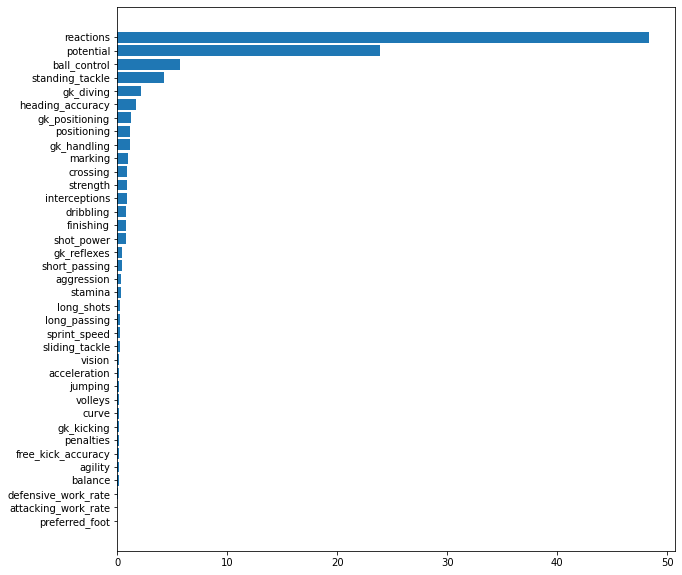

In [29]:
importance = d_tree_reg.feature_importances_

importance = pd.Series(d_tree_reg.feature_importances_)
d = pd.DataFrame({'Importance': (importance)*100, 'ColumnName': d1})
d.sort_values(by='Importance', ascending=True, inplace=True)

# summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.figure(figsize=[10,10])
plt.barh(d['ColumnName'], d['Importance'])
plt.show()

In [31]:
df_top_20 = d.nlargest(20, 'Importance').reset_index()
df_top_20.drop(['index'], axis=1, inplace=True)
df_top_20

,Importance,ColumnName
0,48.300620,reactions
1,23.844913,potential
2,5.700008,ball_control
3,4.268800,standing_tackle
4,2.152917,gk_diving
5,1.729345,heading_accuracy
6,1.282525,gk_positioning
7,1.158987,positioning
8,1.130552,gk_handling
9,0.965466,marking


In [32]:
df_top_20['ColumnName'].values

array(['reactions', 'potential', 'ball_control', 'standing_tackle',
       'gk_diving', 'heading_accuracy', 'gk_positioning', 'positioning',
       'gk_handling', 'marking', 'crossing', 'strength', 'interceptions',
       'dribbling', 'finishing', 'shot_power', 'gk_reflexes',
       'short_passing', 'aggression', 'stamina'], dtype=object)

In [51]:
X_20 = df[['aggression', 'stamina', 'reactions', 'potential', 'positioning', 'ball_control', 'strength', 'marking', 
           'crossing', 'finishing', 'dribbling','interceptions',  'standing_tackle','heading_accuracy', 'shot_power', 
           'short_passing','gk_reflexes', 'gk_handling', 'gk_diving', 'gk_positioning']]

#### Re Building the Models with Top 20 Features

#### Train Test Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_20, Y, test_size=0.3)

#### Linear Regression: Fit a model to the training set

In [53]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [54]:
y_pred = linear_reg.predict(X_test)
y_pred

array([79.54478546, 65.26914322, 64.76666428, ..., 73.99359371,
       68.70168534, 62.9803517 ])

In [55]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')


MAE: 2.186518181601008
MSE: 8.092515847908842
RMSE: 2.8447347587971787


#### Decision Tree Regressor: Fit a new regression model to the training set

In [56]:
d_tree_reg = DecisionTreeRegressor(max_depth=20)
d_tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20)

In [57]:
y_pred = d_tree_reg.predict(X_test)
y_pred

array([75.83333333, 62.46666667, 58.75      , ..., 77.        ,
       71.29411765, 63.        ])

In [58]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')

MAE: 0.7292036660587082
MSE: 2.021604161854793
RMSE: 1.42183127052924


#### Testing the Decision Tree Regressor with 20 Features

In [59]:
X_20.head(1)

,aggression,stamina,reactions,potential,positioning,ball_control,strength,marking,crossing,finishing,dribbling,interceptions,standing_tackle,heading_accuracy,shot_power,short_passing,gk_reflexes,gk_handling,gk_diving,gk_positioning
0,71.0,54.0,47.0,71.0,45.0,49.0,76.0,65.0,49.0,44.0,51.0,70.0,69.0,71.0,55.0,61.0,8.0,11.0,6.0,8.0


In [66]:
data =[[80,65, 50,70,5,80,8,80,65,80,60,80,80,0,80,80,80,80,5,80]]
d_tree_reg.predict(data)

array([66.])

### Pickle File For Deployment

In [67]:
import pickle

# Open a file 
file = open('ml_project.pkl', 'wb')

# dump information to that file
pickle.dump(d_tree_reg,file)

In [70]:
d = np.array([80,65, 50,70,5,80,8,80,65,80,60,80,80,0,80,80,80,80,5,80]).reshape(1,-1)
# Actual Value :- 24

model = pickle.load(open('ml_project.pkl', 'rb'))
prediction = model.predict(d)
output = prediction[0]
output

# Deployed model with 20 attributes

66.0